## Supervised Classifications -- July 22, 2019

In [235]:
import numpy as np
from sklearn.datasets.samples_generator import make_blobs
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.manifold import Isomap
from sklearn import datasets
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from matplotlib import pyplot as plt
import matplotlib as mpl
from hdf5manager import hdf5manager as h5
from pandas import pandas as pd
from pandas import DataFrame
from skimage.measure import label, regionprops
import scipy
import scipy.ndimage.filters as filters
import scipy.ndimage as ndimage
from scipy.ndimage.filters import gaussian_filter, convolve
from scipy.ndimage.morphology import generate_binary_structure, binary_erosion
from scipy.ndimage.filters import maximum_filter
from scipy.stats import multivariate_normal as mvn
from scipy.spatial.distance import cdist
from skimage.morphology import disk, watershed
from skimage.morphology import erosion, dilation, opening, closing
from opticFlow import opticFlow as of
import colorsys
import wholeBrain as wb
from waveletAnalysis import waveletAnalysis as wave
import cv2
import os
import seaborn as sns
from time import time

In [104]:
path = '/Users/emmadionne/Documents/'
file = 'test_angs_mags_metrics.csv'
tsv_output_file = path + file
data = pd.DataFrame.from_csv(tsv_output_file)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  after removing the cwd from sys.path.


In [105]:
indices = []
for i in range(len(data["mov.mean"])):
    if i >= 1445 and i < 2388:
        indices.append(1)
    else:
        indices.append(0)

In [338]:
%matplotlib inline
col_list = list(data)
#puts the paramter on a scale of 0 to 1
data = data.copy()
data -= data.min()
data /= data.max()
data = data.fillna(value=0)

In [339]:
data = data.astype('float64')
a = np.zeros(len(data))
a[1445:2388]=1
data['classification'] = a

In [340]:
var = pd.DataFrame()
var["mov.range"] = data["mov.range"]
var["mov.eventrest"] = data["mov.eventrest"]
var["mov.surfarea"] = data["mov.surfarea"]
var["mov.diffxystd"] = data["mov.diffxystd"]
var["mov.diffmaxevents"] = data["mov.diffmaxevents"]
var["mov.percenterror"] = data["mov.percenterror"]
var["brain.data"] = data["brain.data"]
var["brain.eventrest"] = data["brain.eventrest"]
var["brain.rangemaxmin"] = data["brain.rangemaxmin"]
var["diff.brainmov"] = data["diff.brainmov"]

var_names = ["mov.range", "mov.eventrest", "mov.surfarea", "mov.diffxystd", "mov.diffmaxevents", 
             "mov.percenterror", "brain.data", "brain.eventrest", "brainrangemaxmin", "diff.brainmov"]

## Logistic Regression

In [341]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

y = data.loc[:,'classification']

X_train, X_test, y_train, y_test = train_test_split(var, y, 
            test_size=0.3, random_state=42)
#Logistic Regression
logreg = LogisticRegression(C  = 1, solver = 'liblinear')
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of Logistic Regression classifier on test set:\t\
                {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of Logistic Regression classifier on test set:	                0.89


In [184]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

logreg = LogisticRegression(C=1, solver='lbfgs')
logreg.fit(X_train, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [185]:
y_pred = logreg.predict(X_test)

print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.89


In [186]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
col_list = ['not pred.', 'pred.']
row_list = ['not act.', 'act.']
row_format ="{:>15}" * (len(col_list) + 1)
print(row_format.format("", *col_list))
for rlist, row in zip(row_list, confusion_matrix):
    print(row_format.format(rlist, *row))

                     not pred.          pred.
       not act.            867             45
           act.             85            203


In [187]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.91      0.95      0.93       912
         1.0       0.82      0.70      0.76       288

   micro avg       0.89      0.89      0.89      1200
   macro avg       0.86      0.83      0.84      1200
weighted avg       0.89      0.89      0.89      1200



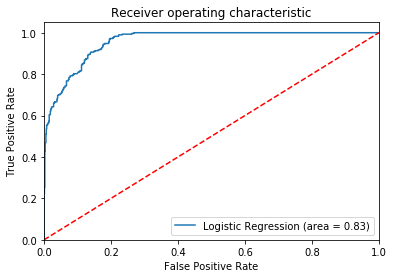

In [188]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

var.loc[X_test.index, 'logreg_prob'] = logreg.predict_proba(X_test)[:, 1]
var.loc[X_train.index, 'logreg_prob'] = logreg.predict_proba(X_train)[:, 1]

## Gaussian Naive Bayes Classifier

In [189]:
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics

gnb = GaussianNB(var_smoothing= 0.25)
gnb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=0.25)

In [190]:
y_pred = gnb.predict(X_test)

print('Accuracy of Gaussian NB classifier on test set: {:.2f}'.format(gnb.score(X_test, y_test)))

Accuracy of Gaussian NB classifier on test set: 0.86


In [191]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
col_list = ['not pred.', 'pred.']
row_list = ['not act.', 'act.']
row_format ="{:>15}" * (len(col_list) + 1)
print(row_format.format("", *col_list))
for rlist, row in zip(row_list, confusion_matrix):
    print(row_format.format(rlist, *row))

                     not pred.          pred.
       not act.            769            143
           act.             25            263


In [192]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.84      0.90       912
         1.0       0.65      0.91      0.76       288

   micro avg       0.86      0.86      0.86      1200
   macro avg       0.81      0.88      0.83      1200
weighted avg       0.89      0.86      0.87      1200



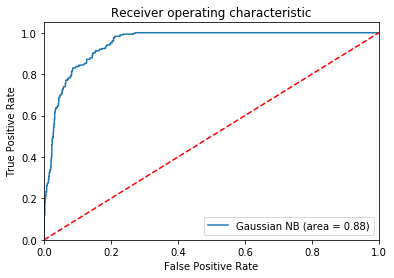

In [193]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

roc_auc = roc_auc_score(y_test, gnb.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, gnb.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Gaussian NB (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

var.loc[X_test.index, 'gnb_prob'] = gnb.predict_proba(X_test)[:,1]
var.loc[X_train.index, 'gnb_prob'] = gnb.predict_proba(X_train)[:,1]

## Support Vector Machine Classifer with Gaussian kernel

In [194]:
from sklearn.svm import SVC

svm_clf = SVC(kernel="rbf", gamma=0.01, C=50, random_state=42, probability= True)
svm_clf.fit(X_train, y_train)

SVC(C=50, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

In [195]:
y_pred = svm_clf.predict(X_test)

print('Accuracy of SVM classifier on test set: {:.2f}'.format(svm_clf.score(X_test, y_test)))

Accuracy of SVM classifier on test set: 0.90


In [196]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
col_list = ['not pred.', 'pred.']
row_list = ['not act.', 'act.']
row_format ="{:>15}" * (len(col_list) + 1)
print(row_format.format("", *col_list))
for rlist, row in zip(row_list, confusion_matrix):
    print(row_format.format(rlist, *row))

                     not pred.          pred.
       not act.            869             43
           act.             83            205


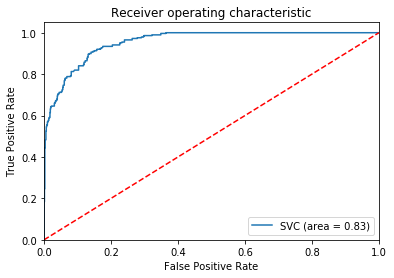

In [197]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

roc_auc = roc_auc_score(y_test, svm_clf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, svm_clf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='SVC (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
# plt.savefig('SVM_ROC.svg')
plt.show()

var.loc[X_test.index, 'SVC_prob'] = svm_clf.predict_proba(X_test)[:,1]
var.loc[X_train.index, 'SVC_prob'] = svm_clf.predict_proba(X_train)[:,1]

## Random Forest Classifier

In [198]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators = 500, max_features = len(var_names), random_state=42)
rnd_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [199]:
y_pred = rnd_clf.predict(X_test)

print('Accuracy of Random Forest classifier on test set: {:.2f}'.format(rnd_clf.score(X_test, y_test)))

Accuracy of Random Forest classifier on test set: 0.99


In [200]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
col_list = ['not pred.', 'pred.']
row_list = ['not act.', 'act.']
row_format ="{:>15}" * (len(col_list) + 1)
print(row_format.format("", *col_list))
for rlist, row in zip(row_list, confusion_matrix):
    print(row_format.format(rlist, *row))

                     not pred.          pred.
       not act.            907              5
           act.              3            285


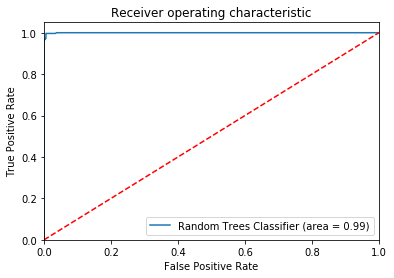

In [201]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

roc_auc = roc_auc_score(y_test, rnd_clf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, rnd_clf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Trees Classifier (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
# plt.savefig('rnd_ROC.svg')
plt.show()

var.loc[X_test.index, 'rnd_clf_prob'] = rnd_clf.predict_proba(X_test)[:,1]
var.loc[X_train.index, 'rnd_clf_prob'] = rnd_clf.predict_proba(X_train)[:,1]

## Voting Classifier

In [202]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


log_clf = LogisticRegression(C=1, solver = 'lbfgs', random_state = 42)
rnd_clf = RandomForestClassifier(n_estimators = 50, max_features = len(var_names), random_state=42)
svm_clf = SVC(kernel="rbf", gamma=0.01, C=50, random_state=42, probability= True)
gnb_clf = GaussianNB(var_smoothing= 0.25)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf), ('gnb', gnb_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)), ('rf', RandomFores... shrinking=True,
  tol=0.001, verbose=False)), ('gnb', GaussianNB(priors=None, var_smoothing=0.25))],
         flatten_transform=None, n_jobs=None, voting='soft', weights=None)

In [203]:
y_pred = voting_clf.predict(X_test)

print('Accuracy of Voting classifier on test set: {:.2f}'.format(voting_clf.score(X_test, y_test)))


Accuracy of Voting classifier on test set: 0.94


In [204]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
col_list = ['not pred.', 'pred.']
row_list = ['not act.', 'act.']
row_format ="{:>15}" * (len(col_list) + 1)
print(row_format.format("", *col_list))
for rlist, row in zip(row_list, confusion_matrix):
    print(row_format.format(rlist, *row))

                     not pred.          pred.
       not act.            883             29
           act.             39            249


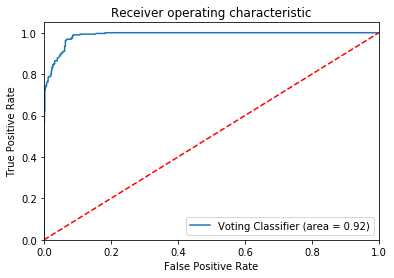

In [205]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

roc_auc = roc_auc_score(y_test, voting_clf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, voting_clf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Voting Classifier (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
# plt.savefig('rnd_ROC.svg')
plt.show()

var.loc[X_test.index, 'voting_clf_prob'] = voting_clf.predict_proba(X_test)[:,1]
var.loc[X_train.index, 'voting_clf_prob'] = voting_clf.predict_proba(X_train)[:,1]


# print(voting_clf.predict_proba(X_test))
# print(voting_clf.predict_proba(X_train))

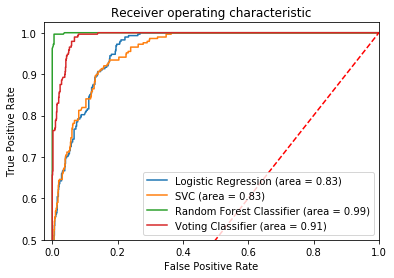

In [207]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

plt.figure()

logreg = LogisticRegression(C=1, solver='lbfgs')
logreg.fit(X_train, y_train)

roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % roc_auc)

svm_clf = SVC(kernel="rbf", gamma=0.01, C=50, random_state=42, probability= True)
svm_clf.fit(X_train, y_train)

roc_auc = roc_auc_score(y_test, svm_clf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, svm_clf.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, label='SVC (area = %0.2f)' % roc_auc)

rnd_clf = RandomForestClassifier(n_estimators = 500, max_features = len(var_names), random_state=42)
rnd_clf.fit(X_train, y_train)

roc_auc = roc_auc_score(y_test, rnd_clf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, rnd_clf.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, label='Random Forest Classifier (area = %0.2f)' % roc_auc)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

roc_auc = roc_auc_score(y_test, voting_clf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, voting_clf.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, label='Voting Classifier (area = %0.2f)' % roc_auc)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.025, 1.0])
plt.ylim([.50, 1.025])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
# plt.savefig('rnd_ROC.svg')
plt.show()

## Big Data Set Classification

In [260]:
path = '/Users/emmadionne/Documents/'
file = '170721_07_c1_gridOpticFlow_metrics.csv'
tsv_output_file = path + file
data_big = pd.DataFrame.from_csv(tsv_output_file)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  after removing the cwd from sys.path.


In [261]:
%matplotlib inline

col_list = list(data_big)

#puts the paramter on a scale of 0 to 1

data_big = data_big.copy()
data_big -= data_big.min()
data_big /= data_big.max()
data_big = data_big.fillna(value=0)

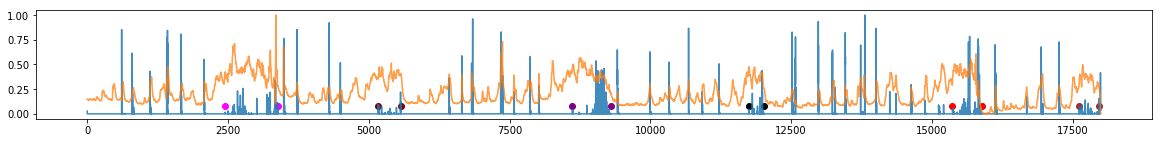

In [343]:
plt.figure(figsize=(20,2))
plt.plot(data_big["mov.mean"], alpha = 0.85)
plt.plot(data_big["brain.data"], alpha = 0.75)
plt.scatter(2445, 0.078, color = "magenta")
plt.scatter(3387, 0.078, color = "magenta")
plt.scatter(5166, 0.078, color = "maroon")
plt.scatter(5568, 0.078, color = "maroon")
plt.scatter(8617, 0.078, color = "purple")
plt.scatter(9297, 0.078, color = "purple")
plt.scatter(11751, 0.078, color = "black")
plt.scatter(12011, 0.078, color = "black")
plt.scatter(15367, 0.078, color = "red")
plt.scatter(15888, 0.078, color = "red")
plt.scatter(17619, 0.078, color = "brown")
plt.scatter(17964, 0.078, color = "brown")

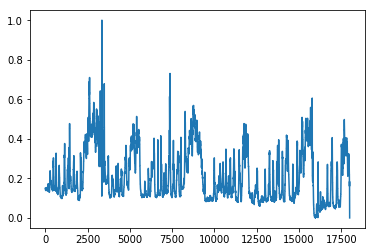

In [263]:
#plt.figure(figsize = (20, 2))
plt.plot(data_big["brain.data"])

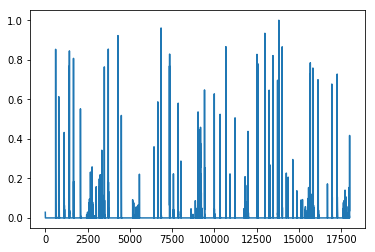

In [264]:
plt.plot(data_big["mov.mean"])

In [333]:
indices_big = np.zeros(len(data_big))
indices_big[2445 : 3388] = 1
indices_big[5166 : 5569] = 1
indices_big[8617 : 9298] = 1
indices_big[11751 : 12024] = 1
indices_big[15367 : 15889] = 1
indices_big[17619 : 17894] = 1
data_big['classification'] = indices_big

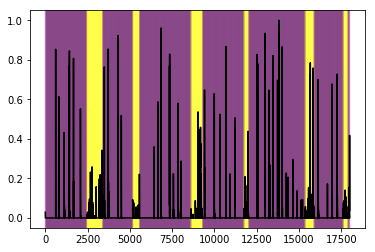

In [334]:
def plot_classification(data, indices, color):
    colors_list = ["violet", "magenta", "teal", "silver", "salmon", "pink"]
    num_color = 0;
    if (len(np.unique(indices)) > 2):
        for i in range(len(indices)):
            if (indices[i] == 0):
                plt.axvline(x = i, color = 'blue', alpha = 0.01)
            elif (indices[i] == 1):
                plt.axvline(x = i, color = 'orange', alpha = 0.01)
            elif (indices[i] == 2):
                plt.axvline(x = i, color = 'green', alpha = 0.01 )
            elif (indices[i] == 3 ):
                plt.axvline(x = i, color = 'purple', alpha = 3)
            else:
                if (num_color == len(colors_list)):
                    num_color = 0
                else:
                    plt.axvline(x = i, color = colors_list[num_color], alpha = 0.01)
                    num_color += num_color
                
    else:
        for i in range(len(indices)):
            if (indices[i] == 1):
                plt.axvline(x = i, color = 'yellow', alpha = 0.01)
            else:
                plt.axvline(x = i, color = 'purple', alpha = 0.01)
    
    plt.plot(data, color)
plot_classification(data_big["mov.mean"], indices_big, "black")